In [1]:
import sys
sys.path.append("/tf/easl-eye")

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

## Local Package
import easl_eye as eye
from easl_eye.io import *
from easl_eye.preprocess import eyes as blink
from easl_eye.viz import raw_gaze_plot, session_video, session_animation

In [3]:
# Loading the two different datasets
image_tracking = get_viewer_tracking_info(url="http://amc-tensor1.ucdenver.pvt/eyetracking")
eye_tracking = load_eyetracking_data(fname="/tf/easl-eye/jupyter/test_gaze_data.csv")

In [4]:
eye_tracking = blink.format_data(eye_tracking, 
                                 screen_size=(59.789,33.631), # cm
                                 screen_res=(2560,1440), # px
                                 viewing_dist=82) # cm

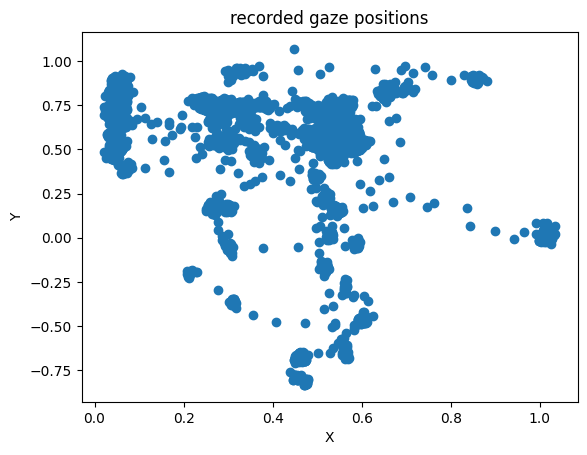

In [5]:
raw_gaze_plot(eye_tracking)

In [6]:
aligned_data = eye.align_tracking_data(image_tracking=image_tracking, eye_tracking=eye_tracking)

/tf/easl-eye/easl_eye/integrate.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_tracking['ui_timestamp_us'] = image_tracking['ui_timestamp'].apply(convert2us)
/tf/easl-eye/easl_eye/integrate.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  image_tracking['adjusted_timestamp'] = image_tracking['ui_timestamp_us'].apply(
/tf/easl-eye/easl_eye/integrate.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = valu

In [7]:
aligned_data = blink.classify(aligned_data , 'right', roi_x=[0.3026622037, 0.82349537], roi_y=[0.148612535, 0.95344673])
aligned_data = blink.classify(aligned_data , 'left', roi_x=[0.3026622037, 0.82349537], roi_y=[0.148612535, 0.95344673])

/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [8]:
# instance_map = eye.build_instance_map()
instance_map = pd.read_csv("./instance_map.csv")

In [9]:
# test_dataset = aligned_data.iloc[:200,:]
# test_dataset = aligned_data.loc[aligned_data.in_roi_filter_x == True].loc[aligned_data.in_roi_filter_y == True]
test_dataset = aligned_data.iloc[1200:1800,:]

In [10]:
images = [eye.get_pixel_array(aligned_data.current_uid[i], instance_map) for i in [3]]

In [11]:
session_animation(
    test_dataset, 
    instance_map, 
    dims=(900, 900), 
    return_array=False, 
    overlay_eyetracking=True
)

compiling frames
frames compiled


AttributeError: 'NoneType' object has no attribute 'canvas'

In [12]:
images

[array([[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  1,  0,  0],
        [ 0,  0,  0, ...,  1,  0,  0],
        ...,
        [ 0,  6,  3, ...,  7, 10, 12],
        [ 0,  8,  6, ...,  8, 11, 13],
        [ 0,  6,  5, ..., 10, 12, 12]], dtype=uint16)]

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.animation as animation
import numpy as np

# Assume that images is your list of images
images = [eye.get_pixel_array(aligned_data.current_uid[i], instance_map) for i in range(3,100)]

fig, ax = plt.subplots()

# Display the first image
im = ax.imshow(images[0])

# Add a patch to the Axes
patch = patches.Rectangle((10, 10), 200, 300, edgecolor='green', facecolor=(0,0,0,0), lw=2)
ax.add_patch(patch)

# Update function for the animation
def update(i):
    # Update the image data
    im.set_array(images[i])
    # Update the patch position
    patch.set_xy((i, i))
    return im, patch

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(images), blit=True)
ani.save('/tf/easl-eye/jupyter/ani.mp4')

ValueError: list.remove(x): x not in list

In [22]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.patches as patches
import numpy as np
import cv2
from skimage import filters

dims = (900,900)

# Assume that images is your list of images
images = [eye.get_pixel_array(aligned_data.current_uid[i], instance_map) for i in range(len(aligned_data.current_uid))]
images = [cv2.resize(image, dims) for image in images]
# et = aligned_data.iloc[1200:1800,]
et = aligned_data

fig, ax = plt.subplots()

# Display the first image
im = ax.imshow(images[0], cmap=plt.cm.bone)

# Create a scatter plot
scatter = ax.scatter([], [], color='r', s=100)

# Create a rectangle for the bounding box
patch = patches.Rectangle((10, 10), 200, 300, edgecolor='green', facecolor=(0,0,0,0), lw=2)
ax.add_patch(patch)

# Update function for the animation
def update(i):
    # Update the image data
    im.set_array(images[i])
    
    if et.in_roi_filter_x[i] and et.in_roi_filter_y[i]:
        if et.segment_class[i] == 'Fixation':
            
            center_point = (
					int(et.right_roi_filter_scaled_x[i]), 
					int(et.right_roi_filter_scaled_y[i])
				)
            
            if center_point[0] > 0 and center_point[1] > 0:
                edges = filters.sobel(images[i])
                bounding_box = eye.basic_expand(edges, center_point, buffer=0.1)

                # Update the rectangle position
                patch.set_xy((bounding_box[0], bounding_box[1]))
                patch.set_width(bounding_box[2] - bounding_box[0])
                patch.set_height(bounding_box[3] - bounding_box[1])
            else:
                patch.set_xy((0,0))
                patch.set_width(0)
                patch.set_height(0)
        else:
            # Update the scatter plot data
            x = et.right_roi_filter_scaled_x.values[i]
            y = et.right_roi_filter_scaled_y.values[i]
            scatter.set_offsets(np.c_[x, y])

    return im, scatter

# Create the animation
ani = animation.FuncAnimation(fig, update, frames=len(images), blit=True)
ani.save('/tf/easl-eye/jupyter/ani.mp4')

IndexError: index 985 is out of bounds for axis 0 with size 900

In [20]:
# %% environment and functions
import numpy as np
import matplotlib.pyplot as plt
import os
join = os.path.join
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F

ModuleNotFoundError: No module named 'torch'

In [52]:


def segment_image(aligned_data, idx, bbox=None, save_path=None):
    ## Get bounding box info from eye-tracking data
    tmp = aligned_data.loc[aligned_data['current_uid'] == aligned_data.current_uid[idx], 
                           ['right_x', 'right_y', 'left_x', 'left_y']]
    
    tmp['right_x'] = tmp['right_x'].apply(float) * 900
    tmp['right_y'] = tmp['right_y'].apply(float) * 900
    tmp['left_x'] = tmp['left_x'].apply(float) * 900
    tmp['left_y'] = tmp['left_y'].apply(float) * 900
    
    x1 = min([tmp['right_x'].min(), tmp['left_x'].min()])
    x2 = max([tmp['right_x'].max(), tmp['left_x'].max()])
    y1 = min([tmp['right_y'].min(), tmp['left_y'].min()])
    y2 = max([tmp['right_y'].max(), tmp['left_y'].max()])
    
    ## Get Image
    img_np = eye.get_pixel_array(aligned_data.current_uid[idx], instance_map)
    img_np = transform.resize(img_np, (900, 900), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape
    
    #%% image preprocessing and model inference
    img_1024 = transform.resize(img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    # convert the shape to (3, H, W)
    img_1024_tensor = torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    
    # box_np = np.array([[95,255, 190, 350]])
    if bbox is None:
        box_np = np.array([[x1, y1, x2, y2]])
    else:
        box_np = bbox
    print(box_np)
    # transfer box_np t0 1024x1024 scale
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor) # (1, 256, 64, 64)
    
    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)

    #%% visualize results
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_3c, cmap=plt.cm.bone)
    show_box(box_np[0], ax[0])
    ax[0].set_title("Input Image and Eye Tracking Bounding Box")
    ax[1].imshow(img_3c, cmap=plt.cm.bone)
    show_mask(medsam_seg, ax[1])
    show_box(box_np[0], ax[1])
    ax[1].set_title("MedSAM Segmentation")
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')

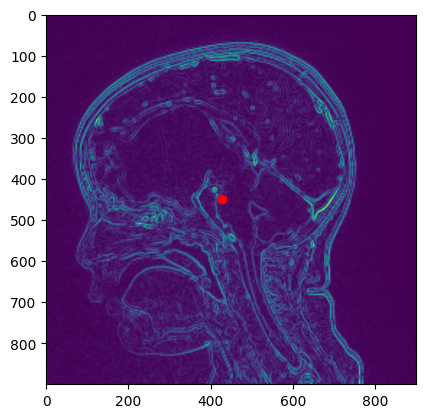

In [55]:
plt.imshow(edges)
plt.scatter(center_point[0], center_point[1], color='r')
plt.show()

In [21]:
len(aligned_data.current_uid)

9474